<a href="https://colab.research.google.com/github/sandrinix88/Carrie-Gpt/blob/main/CarrieGPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP & IMPORTS

In [2]:
# =============================================================================
# SETUP & IMPORTS
# =============================================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -q transformers datasets peft accelerate bitsandbytes sentence-transformers faiss-cpu
!pip install bertopic spacy
!python -m spacy download en_core_web_sm

# =============================================================================
# CORE LIBRARIES
# =============================================================================

# System & Data Processing
import pandas as pd
import numpy as np
import re
import json
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch

# =============================================================================
# NLP LIBRARIES
# =============================================================================

# Core NLP
import spacy
from bertopic import BERTopic

# NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Scikit-Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

# Transformers & Hugging Face
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

# Sentence Transformers & Vector Search
from sentence_transformers import SentenceTransformer
import faiss

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training

# =============================================================================
# LOAD EXTERNAL DATA
# =============================================================================

# Load theme labels
with open("/content/drive/MyDrive/Colab Notebooks/theme_labels.json", "r") as f:
    theme_labels = json.load(f)

print("✅ Setup complete! All libraries imported and theme labels loaded.")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 122.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Setup complete! All libraries imported and theme labels loaded.


In [3]:
# =============================================================================
# DATA PREPARATION
# =============================================================================

print("📊 Loading datasets...")

# Load datasets
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SATC_all_lines.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/imdb_eps.csv")

print(f"✅ Loaded {len(df1)} total lines from SATC dataset")
print(f"✅ Loaded {len(df2)} episode records from IMDB dataset")


📊 Loading datasets...
✅ Loaded 39208 total lines from SATC dataset
✅ Loaded 94 episode records from IMDB dataset


In [5]:
# Display basic info about the datasets
print("\n Dataset overview:")
print("All lines dataset columns:", df1.columns.tolist())
print("IMDB episodes dataset columns:", df2.columns.tolist())

# Show first few rows
print("\n Sample data:")
print(df1.head())


 Dataset overview:
All lines dataset columns: ['Unnamed: 0', 'Season', 'Episode', 'Speaker', 'Line', 'date_job']
IMDB episodes dataset columns: ['ep_data_name', 'ep_data_url', 'Season', 'Episode', 'ID']

 Sample data:
   Unnamed: 0  Season  Episode Speaker  \
0           0       1        1  Carrie   
1           1       1        1  Carrie   
2           2       1        1  Carrie   
3           3       1        1     Tim   
4           4       1        1  Carrie   

                                                Line date_job  
0  Once upon a time, an English journalist came t...      NaN  
1               Elizabeth was attractive and bright.      NaN  
2  Right away she hooked up with one of the city'...      NaN  
3  The question remains Is this really a company ...      NaN  
4  Tim was 42, a wellliked and respected investme...      NaN  


In [6]:
# Filter for Carrie's lines only
print("\n Extracting Carrie's lines...")
carrie_df = df1[df1['Speaker'] == 'Carrie'].copy()  # .copy() to avoid warnings

print(f"✅ Found {len(carrie_df)} lines spoken by Carrie")
print(f"📈 Carrie speaks {len(carrie_df)/len(df1)*100:.1f}% of all lines")


 Extracting Carrie's lines...
✅ Found 13941 lines spoken by Carrie
📈 Carrie speaks 35.6% of all lines


In [7]:
# Display Carrie's data
print("\n Carrie's lines preview:")
print(carrie_df.head())



 Carrie's lines preview:
   Unnamed: 0  Season  Episode Speaker  \
0           0       1        1  Carrie   
1           1       1        1  Carrie   
2           2       1        1  Carrie   
4           4       1        1  Carrie   
5           5       1        1  Carrie   

                                                Line date_job  
0  Once upon a time, an English journalist came t...      NaN  
1               Elizabeth was attractive and bright.      NaN  
2  Right away she hooked up with one of the city'...      NaN  
4  Tim was 42, a wellliked and respected investme...      NaN  
5  They met one evening, in typical New York fash...      NaN  


In [8]:
# Basic text statistics
print("\n Text Statistics:")
carrie_lines = carrie_df['Line'].dropna()  # Remove any NaN values
print(f"Total lines: {len(carrie_lines)}")
print(f"Average line length: {carrie_lines.str.len().mean():.1f} characters")
print(f"Longest line: {carrie_lines.str.len().max()} characters")
print(f"Shortest line: {carrie_lines.str.len().min()} characters")


 Text Statistics:
Total lines: 13941
Average line length: 44.6 characters
Longest line: 718 characters
Shortest line: 2 characters


# 3. EXPLORATORY ANALYSIS & TEXT PROCESSING

In [9]:
# =============================================================================
# 3. EXPLORATORY ANALYSIS & TEXT PROCESSING
# =============================================================================

# Initialize spacy
nlp = spacy.load("en_core_web_sm")


# =============================================================================
# IMPROVED TEXT CLEANING (Replace your current cleaning)
# =============================================================================

def clean_line_v2(text):
    """Less aggressive cleaning to preserve topic diversity"""
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Remove character names but keep more context
    character_names = ["samantha", "charlotte", "miranda", "steve",
                      "aidan", "carrie", "big", "natasha"]

    for name in character_names:
        text = text.replace(name, "")

    # Basic cleaning but keep more words
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation but keep words
    text = re.sub(r'\s+', ' ', text)      # Fix multiple spaces

    return text.strip()

def keep_meaningful_words(text):
    """Keep more word types for better topic diversity"""
    if not text:
        return ""

    doc = nlp(text)
    meaningful_words = [token.lemma_.lower() for token in doc
                       if (token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"]
                           and not token.is_stop
                           and len(token.text) > 2
                           and token.is_alpha)]
    return " ".join(meaningful_words)

# Re-clean with better approach
print("🔄 Re-cleaning with improved method...")
carrie_df['cleaned_line_v2'] = (carrie_df['Line']
                               .apply(clean_line_v2)
                               .apply(keep_meaningful_words))

# Filter out empty lines
carrie_df = carrie_df[carrie_df['cleaned_line_v2'].str.len() > 10].reset_index(drop=True)
print(f"✅ Kept {len(carrie_df)} lines after improved cleaning")

🔄 Re-cleaning with improved method...
✅ Kept 7870 lines after improved cleaning


In [ ]:
# =============================================================================
# IMPROVED BERTOPIC ANALYSIS
# =============================================================================

print("🎯 Re-running theme analysis with better parameters...")

# Initialize SentenceTransformer model
sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")

# New embeddings with improved text
text_embeddings_v2 = sentence_transformer.encode(
    carrie_df['cleaned_line_v2'].tolist(),
    show_progress_bar=True
)

# Better BERTopic parameters
topic_model_v2 = BERTopic(
    nr_topics="auto",
    min_topic_size=10,           # Smaller min size
    n_gram_range=(1, 2),         # Include bigrams
    embedding_model=sentence_transformer
)

# Fit the model
topics_v2, probs_v2 = topic_model_v2.fit_transform(carrie_df['cleaned_line_v2'].tolist())

print(f"✅ Found {len(topic_model_v2.get_topics())} themes initially")

# Less aggressive reduction
topic_model_v2 = topic_model_v2.reduce_topics(carrie_df['cleaned_line_v2'].tolist(), nr_topics=20)

# Update dataframe
final_topics_v2, _ = topic_model_v2.transform(carrie_df['cleaned_line_v2'].tolist())
carrie_df['theme_id_v2'] = final_topics_v2

print(f"📊 Distribution check:")
print(carrie_df['theme_id_v2'].value_counts().head())

🎯 Re-running theme analysis with better parameters...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/246 [00:00<?, ?it/s]

✅ Found 44 themes initially


In [ ]:
# =============================================================================
# EXPLORE THE IMPROVED THEMES
# =============================================================================

print("\n🎨 Exploring improved themes...")

# Get topic information from the NEW model
topics_dict_v2 = topic_model_v2.get_topics()
print(f"Number of themes found: {len(topics_dict_v2)}")

# Show theme keywords from the NEW analysis
print("\n📋 Theme keywords from improved analysis:")
for topic_id, words in topics_dict_v2.items():
    if topic_id != -1:  # Skip outlier topic
        keywords = [word[0] for word in words[:5]]
        print(f"Theme {topic_id}: {', '.join(keywords)}")

# Check distribution of NEW themes
print(f"\n📊 New theme distribution:")
theme_dist_v2 = carrie_df['theme_id_v2'].value_counts().sort_index()
for theme_id, count in theme_dist_v2.head(10).items():
    percentage = (count / len(carrie_df)) * 100
    print(f"Theme {theme_id}: {count} lines ({percentage:.1f}%)")

# Apply theme labels to the NEW themes (you'll need to update your JSON or create new mappings)
print("\n🏷️ Note: You'll need to update theme_labels.json for the new theme IDs")

# For now, show sample lines from each NEW theme
print("\n📋 Sample lines from new themes:")
for theme_id in theme_dist_v2.head(5).index:
    sample_line = carrie_df[carrie_df['theme_id_v2'] == theme_id]['Line'].iloc[0]
    print(f"Theme {theme_id}: {sample_line[:100]}...")

In [101]:


print("\n📋 Sample themed lines from all themes:")

# Group by theme and take 1 sample per theme
sample_per_theme = carrie_df.groupby('theme_id').apply(lambda x: x.sample(1)).reset_index(drop=True)

for idx, row in sample_per_theme.iterrows():
    theme_label = row['label']
    print(f"Theme {row['theme_id']} ({theme_label}): {row['Line'][:150]}...")



📋 Sample themed lines from all themes:
Theme -1 (Love & Identity): No one wants that information....
Theme 0 (Love & Identity): If giving a man the keys to your apartment means unlocking the door to home cooking and great sex "why were so many independent women" ...
Theme 1 (Money & Status):  What street are we on, again? That Sunday, Samantha went to church....
Theme 2 (Career & Culture): So, Joe, the new Yankee How'd you like your first fashion party? ...
Theme 3 (Movement & Escape): I have to write my column. I can't turn it in late again....
Theme 4 (Writing & Voice): He'd smile, and he'd have braces too....
Theme 5 (Communication): Berger, do you want me to talk to my new editor? ...
Theme 6 (Spirituality): and drive the distance to get closer to Berger....
Theme 7 (Animals & Chaos): get the same treatment when it comes to cancer....
Theme 8 (Places & Objects): The right side of my brain told me to delete it....
Theme 9 (Self-Image & Care): Vaughn seduced with chocolate chip cook

/tmp/ipython-input-3864689364.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_per_theme = carrie_df.groupby('theme_id').apply(lambda x: x.sample(1)).reset_index(drop=True)


In [ ]:
# =============================================================================
# VISUALIZE IMPROVED THEME DISTRIBUTION
# =============================================================================

print("\n📊 Creating plot for improved theme distribution...")

# Count themes from the improved analysis
theme_counts_v2 = carrie_df['theme_id_v2'].value_counts().sort_index()

# Get theme names for plotting (using the same logic as before, but for v2 themes)
theme_names_v2 = []
for theme_id in theme_counts_v2.index:
    # You might want to update theme_labels.json or manually create labels for v2 themes
    # For now, we'll use generic labels or try to map if possible
    if str(theme_id) in theme_labels:
         name = theme_labels[str(theme_id)].get('label', f'Theme {theme_id}')
    else:
         name = f'Theme {theme_id}'
    theme_names_v2.append(name)


# Create plot
plt.figure(figsize=(14, 8))
bars_v2 = plt.bar(range(len(theme_counts_v2)), theme_counts_v2.values, color='lightcoral', alpha=0.7)

# Customize plot
plt.title('Distribution of Themes (Improved Analysis) in Carrie\'s Dialogue', fontsize=16, fontweight='bold')
plt.xlabel('Theme', fontsize=12)
plt.ylabel('Number of Lines', fontsize=12)
plt.xticks(range(len(theme_names_v2)), theme_names_v2, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars_v2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(theme_counts_v2.values[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"✅ Visualized improved theme distribution across {len(carrie_df)} lines.")


📊 Creating theme distribution plot...


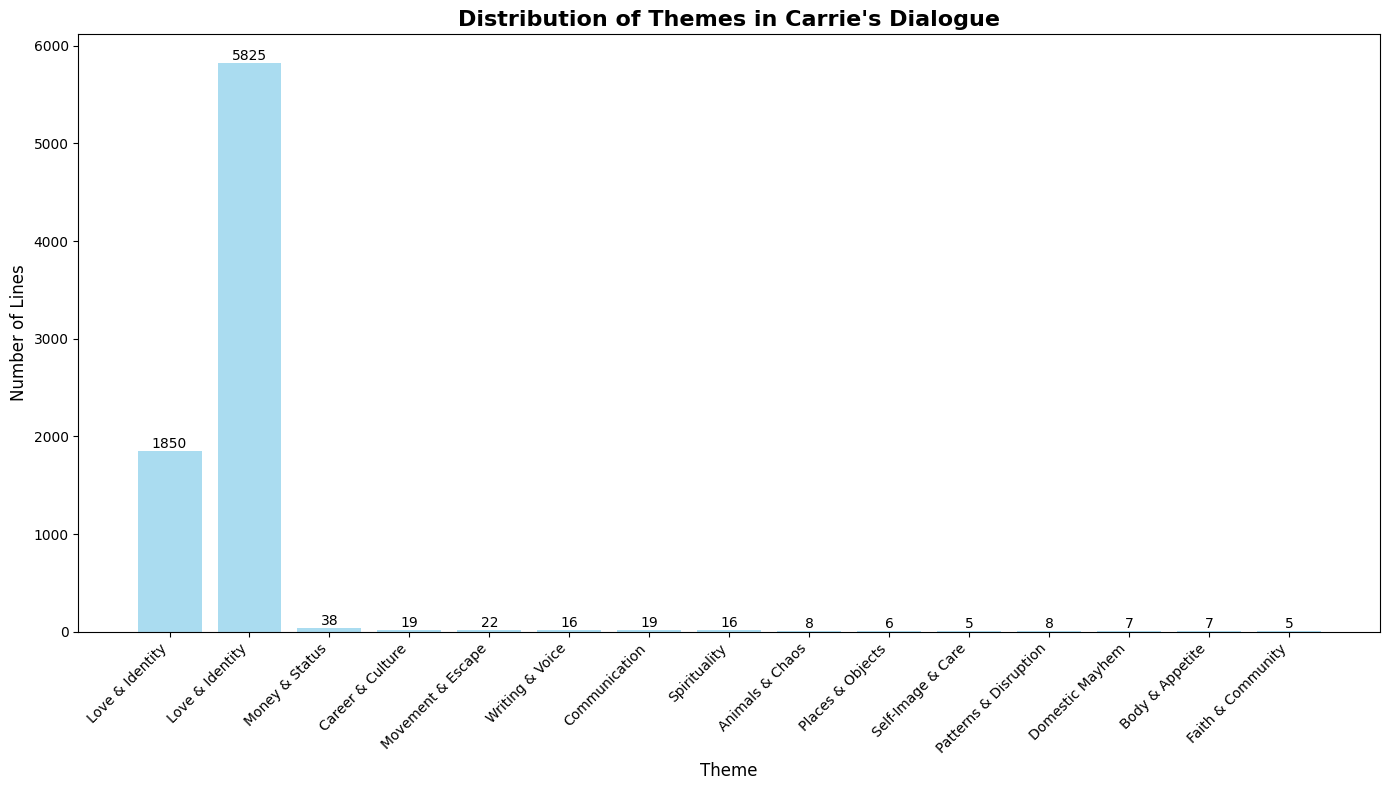

✅ Theme analysis complete! Found 15 themes across 7851 lines


In [102]:
# =============================================================================
# VISUALIZE THEME DISTRIBUTION
# =============================================================================

print("\n📊 Creating theme distribution plot...")

# Count themes
theme_counts = carrie_df['theme_id'].value_counts().sort_index()
#theme_counts = carrie_df[carrie_df['theme_id'] != -1]['theme_id'].value_counts().sort_index()
# Get theme names for plotting
theme_names = []
for theme_id in theme_counts.index:
    if str(theme_id) in theme_labels:
        name = theme_labels[str(theme_id)]['label']
    else:
        name = f'Theme {theme_id}'
    theme_names.append(name)

# Create plot
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(theme_counts)), theme_counts.values, color='skyblue', alpha=0.7)

# Customize plot
plt.title('Distribution of Themes in Carrie\'s Dialogue', fontsize=16, fontweight='bold')
plt.xlabel('Theme', fontsize=12)
plt.ylabel('Number of Lines', fontsize=12)
plt.xticks(range(len(theme_names)), theme_names, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(theme_counts.values[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"✅ Theme analysis complete! Found {len(theme_counts)} themes across {len(carrie_df)} lines")


In [1]:
# Check theme distribution
print("Theme distribution:")
theme_stats = carrie_df['carrie_label'].value_counts()
print(theme_stats)

# See percentage breakdown
print("\nPercentage breakdown:")
print((theme_stats / len(carrie_df) * 100).round(1))

Theme distribution:


NameError: name 'carrie_df' is not defined

In [ ]:
# =============================================================================
# 4. RAG SYSTEM SETUP
# =============================================================================

print("\n🔍 Setting up RAG (Retrieval-Augmented Generation) system...")

# Build FAISS index for fast similarity search
print("🗃️ Building FAISS index...")
dimension = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(text_embeddings.astype('float32'))

# Prepare metadata for retrieval
retrieval_metadata = carrie_df[['Line', 'theme_id', 'label', 'carrie_label']].to_dict(orient='records')

print(f"✅ FAISS index built with {faiss_index.ntotal} vectors of dimension {dimension}")

In [ ]:
# =============================================================================
# RETRIEVAL FUNCTION
# =============================================================================

def retrieve_carrie_lines(query, k=3):
    """
    Retrieve the most similar Carrie lines for a given query

    Args:
        query (str): The question or topic to search for
        k (int): Number of lines to retrieve

    Returns:
        list: Retrieved lines with theme information
    """
    # Encode the query
    query_embedding = sentence_transformer.encode([query]).astype('float32')

    # Search in FAISS index
    distances, indices = faiss_index.search(query_embedding, k)

    # Collect results
    results = []
    for i, idx in enumerate(indices[0]):
        line_data = retrieval_metadata[idx]
        results.append({
            "line": line_data['Line'],
            "theme": line_data['carrie_label'],
            "theme_id": line_data['theme_id'],
            "similarity_score": float(distances[0][i])
        })

    return results


In [ ]:
# =============================================================================
# GENERATION MODEL SETUP
# =============================================================================

print("\n🤖 Loading generation model...")

# Load Flan-T5 for text generation
generation_model_name = "google/flan-t5-large"
generation_tokenizer = AutoTokenizer.from_pretrained(generation_model_name)
generation_model = AutoModelForSeq2SeqLM.from_pretrained(generation_model_name)

print(f"✅ Loaded {generation_model_name} for text generation")

In [ ]:
# =============================================================================
# RAG PIPELINE FUNCTION
# =============================================================================

def generate_carrie_response(question, k=3):
    """
    Complete RAG pipeline: retrieve relevant lines and generate response

    Args:
        question (str): User's question
        k (int): Number of lines to retrieve for context

    Returns:
        dict: Generated response with context information
    """
    # Step 1: Retrieve relevant lines
    retrieved_lines = retrieve_carrie_lines(question, k=k)

    # Step 2: Extract context and theme
    context_lines = [item['line'] for item in retrieved_lines]
    main_theme = retrieved_lines[0]['theme'] if retrieved_lines else 'General'

    # Step 3: Create thematic inspiration (not direct quotes)
    inspirational_context = "\n".join([
        f"- Theme of {item['theme']}: emotional undertone from line"
        for item in retrieved_lines[:3]
    ])

    # Step 4: Construct prompt
    prompt = (
    f"You are Carrie Bradshaw from Sex and the City.\n"
    f"The theme of this question relates to: '{main_theme}'.\n"
    f"Create an original response in a romantic, ironic style.\n"
    f"Create a complex answer with humour, at least 3 sentences.\n"
    f"Do not copy any existing dialogue or example. Use these themes as inspiration.\n\n"

    f"Example of Carrie’s style:\n"
    f"Question: Why do we fall in love with the wrong people?\n"
    f"Carrie's response: Maybe the heart isn’t a GPS — it doesn’t care about the right turn, it only cares about the thrill of the ride.\n\n"

    f"Example of Carrie’s style:\n"
    f"Question: What is love, really?\n"
    f"Carrie's response: Love is like a pair of designer shoes on sale — sometimes it fits perfectly, sometimes it gives you blisters, but you can’t resist taking it home.\n\n"

    f"Example of Carrie’s style:\n"
    f"Question: Why do we fear being alone?\n"
    f"Carrie's response: Maybe loneliness isn’t the absence of company, but the echo of our own thoughts when the city goes quiet. And sometimes, that silence is scarier than heartbreak.\n\n"

    f"Now it’s your turn.\n"
    f"Themes for inspiration:\n{inspirational_context}\n\n"
    f"Question: {question}\n"
    f"Carrie's response:"
)

    # Step 5: Generate response
    inputs = generation_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        outputs = generation_model.generate(
            **inputs,
            min_length=40,
            max_length=200,
            temperature=0.8,
            top_p=0.9,
            do_sample=True,
            pad_token_id=generation_tokenizer.eos_token_id
        )

    # Step 6: Decode and format
    response = generation_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove the prompt from the response
    if "Carrie's response:" in response:
        response = response.split("Carrie's response:")[-1].strip()

    return {
        "question": question,
        "response": response,
        "retrieved_context": retrieved_lines,
        "main_theme": main_theme
    }


In [ ]:
# =============================================================================
# TEST THE SYSTEM
# =============================================================================

print("\n🎬 Testing CarrieGPT system...")

# Test question
test_question = "why do people feel lonely at parties?"

# Generate response
result = generate_carrie_response(test_question, k=3)

# Display results
print(f"\n❓ Question: {result['question']}")
print(f"\n🎭 Main Theme: {result['main_theme']}")

print(f"\n📚 Retrieved Context Lines:")
for i, line in enumerate(result['retrieved_context'], 1):
    print(f"{i}. [{line['theme']}] {line['line'][:100]}...")

print(f"\n💬 CarrieGPT Response:")
print(result['response'])

print("\n✅ RAG system is ready! Use generate_carrie_response(question) to chat with CarrieGPT")

Question: Tell me a short love story.
CarrieGPT Response:
When my girlfriend was a little girl, I thought love was like a snuff film — there were no expectations, no rules, no drama. I mean, the filming was just a routine teen angst fest, and I was really looking forward to the final product.

🎬 Testing CarrieGPT system...

❓ Question: Are breakups like bad shoes ?

🎭 Main Theme: Is Wanting Him Back Just Another Way of Not Letting Go?

📚 Retrieved Context Lines:
1. [Is Wanting Him Back Just Another Way of Not Letting Go?] All ending in breakups....
2. [Is Wanting Him Back Just Another Way of Not Letting Go?]  And, Mr. President, it was a bad breakup....
3. [Is Wanting Him Back Just Another Way of Not Letting Go?] Now it's breakup....

💬 CarrieGPT Response:
They are, you know, bad shoes. And it’s not just you who wear them. It’s your feet. They can get blisters. And it’s the same with love.